In [0]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray
from matplotlib import pyplot
import numpy as np
import re
import sympy
np.set_printoptions(suppress=True)

In [0]:
# define data
x = asarray([i/500 for i in range(-500,500)])
y = asarray([np.power(i,3)/np.power(2, (i/(abs(i)+1))) for i in x])

x = x.reshape((len(x), 1))
y = y.reshape((len(y), 1))

scale_x = MinMaxScaler()
x = scale_x.fit_transform(x)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(y)

In [0]:
# define and run model
model = Sequential()
model.add(Dense(5, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
# model.add(Dense(2, input_dim=1, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1, name='Output'))

model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=200, batch_size=10, verbose=0)
yhat = model.predict(x)

In [0]:
# inverse transforms
x_plot = scale_x.inverse_transform(x)
y_plot = scale_y.inverse_transform(y)
yhat_plot = scale_y.inverse_transform(yhat)

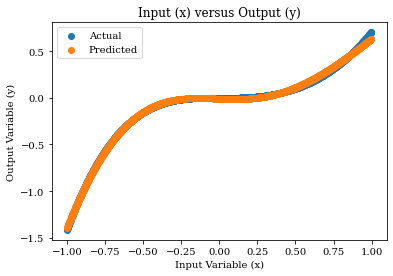

In [111]:
# plot x vs yhat
pyplot.scatter(x_plot,y_plot, label='Actual')
pyplot.scatter(x_plot,yhat_plot, label='Predicted')
pyplot.title('Input (x) versus Output (y)')
pyplot.xlabel('Input Variable (x)')
pyplot.ylabel('Output Variable (y)')
pyplot.legend()
pyplot.show()

In [112]:
### Conversion to Basic Formula

# temp list as a container for each layer formulas
formula_list = []
# counter of hidden layers
f_n = 1
#
for i in range(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[i]
    W = layer.get_weights()
    # empty text string to which concatenate current layer formula parts
    formula = ''
    # set script for input layer
    if i == 0:
        for i in range(W[0].shape[1]):
            cur_weight = np.sum(W[0][0,i])
            cur_bias = np.sum(W[1][i])
            # build formula for this layer
            formula += '*'+str(np.round(cur_weight,2))+'*'+'x+'+'*'+str(np.round(cur_bias,2)) + '*'+ '/'
        # append this layer formula to temp list
        formula_list.append(formula)

    # set script for hidden layers
    elif i < len(model.layers)-1:
        # start loop for next layer each neuron
        for c in range(W[0].shape[1]):
            cur_bias = np.sum(W[1][c])
            for i in range(W[0].shape[0]):
                cur_weight = np.sum(W[0][i, c])
                # build formula for this layer using previous layer formula
                formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
            formula += '*'+str(np.round(cur_bias,2))+'*' + '/'
        # append this layer formula to temp list
        formula_list.append(formula)
        # increase index number for the next hidden layer
        f_n+=1
    # set script for output layer
    else:
        for i in range(W[0].shape[0]):
            cur_weight = np.sum(W[0][i, 0])
            # build formula for this layer using previous layer formula
            formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
        cur_bias = np.sum(W[1][0])
        formula += '*'+str(np.round(cur_bias,2))+'*'
        # append this layer formula to temp list
        formula_list.append(formula)
# get last formula
formula = formula_list[-1]
# make some cleanings
formula = formula.replace('+*-','-')
formula = formula.replace('+*0.0*','')
formula = formula.replace('-*0.0*','')
formula = formula.replace('*','')
print(formula)

0.71f1(-2.74x+1.28)f1-1.25f1(-0.9x+0.66)f1-0.86f1(-0.78x+0.27)f1+0.86f1(3.98x+0.4)f1+0.03f1(0.9x+0.1)f1+0.02


In [113]:
# create LaTeX code
def latex_activation_function(x):
    return '\\frac{e^{'+x+'} - e^{-'+x+'}}{e^{'+x+'} + e^{-'+x+'}}'


formula_latex = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_latex).group(1)
            start = re.search(pattern, formula_latex).start()
            formula_latex = formula_latex[:start] + latex_activation_function(substring) + formula_latex[start + 4 + len(substring):]
        except:
            exist = False

print(formula_latex)

0.71\frac{e^{(-2.74x+1.28)} - e^{-(-2.74x+1.28)}}{e^{(-2.74x+1.28)} + e^{-(-2.74x+1.28)}}-1.25\frac{e^{(-0.9x+0.66)} - e^{-(-0.9x+0.66)}}{e^{(-0.9x+0.66)} + e^{-(-0.9x+0.66)}}-0.86\frac{e^{(-0.78x+0.27)} - e^{-(-0.78x+0.27)}}{e^{(-0.78x+0.27)} + e^{-(-0.78x+0.27)}}+0.86\frac{e^{(3.98x+0.4)} - e^{-(3.98x+0.4)}}{e^{(3.98x+0.4)} + e^{-(3.98x+0.4)}}+0.03\frac{e^{(0.9x+0.1)} - e^{-(0.9x+0.1)}}{e^{(0.9x+0.1)} + e^{-(0.9x+0.1)}}+0.02


In [114]:
# Create numpy formula
def numpy_activation_function(x):
    return '(np.exp('+x+') - np.exp(-'+x+'))/(np.exp('+x+') + np.exp(-'+x+'))'


formula_numpy = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_numpy).group(1)
            start = re.search(pattern, formula_numpy).start()
            formula_numpy = formula_numpy[:start] + numpy_activation_function(substring) + formula_numpy[start + 4 + len(substring):]
        except:
            exist = False

formula_numpy = formula_numpy.replace('(np', '*(np')
formula_numpy = formula_numpy.replace('x-', '*x-')
formula_numpy = formula_numpy.replace('x+', '*x+')
formula_numpy = formula_numpy.replace('/*', '/')

print(formula_numpy)

0.71*(np.exp((-2.74*x+1.28)) - np.exp(-(-2.74*x+1.28)))/(np.exp((-2.74*x+1.28)) + np.exp(-(-2.74*x+1.28)))-1.25*(np.exp((-0.9*x+0.66)) - np.exp(-(-0.9*x+0.66)))/(np.exp((-0.9*x+0.66)) + np.exp(-(-0.9*x+0.66)))-0.86*(np.exp((-0.78*x+0.27)) - np.exp(-(-0.78*x+0.27)))/(np.exp((-0.78*x+0.27)) + np.exp(-(-0.78*x+0.27)))+0.86*(np.exp((3.98*x+0.4)) - np.exp(-(3.98*x+0.4)))/(np.exp((3.98*x+0.4)) + np.exp(-(3.98*x+0.4)))+0.03*(np.exp((0.9*x+0.1)) - np.exp(-(0.9*x+0.1)))/(np.exp((0.9*x+0.1)) + np.exp(-(0.9*x+0.1)))+0.02


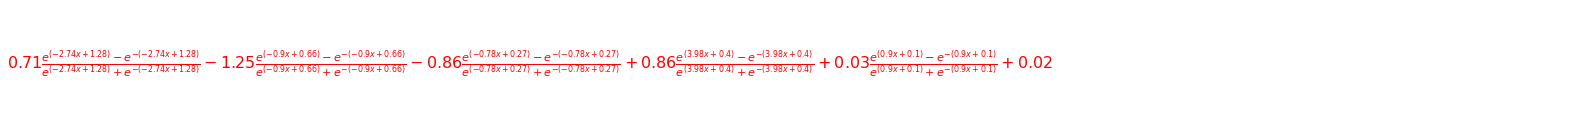

In [115]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
rc("text", usetex=False)
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(22, 2), tight_layout=True)
plt.axis('off')
ax.text(0,0.5,r'$'+formula_latex+'$', fontsize=16, color='r', )
plt.show()